<a href="https://colab.research.google.com/github/mallicksiddartha/FCC_TF_classifier/blob/main/nn_text_classifier_tutorial_fcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

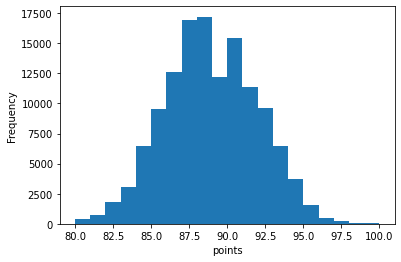

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as tf_hub

##just upload the dataset
data_file = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
data_file = data_file.dropna(subset=['description', 'points'])
plt.hist(data_file.points, bins= 20)
plt.ylabel('Frequency')
plt.xlabel('points')
plt.show()



In [2]:
data_file.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
data_file['label'] = (data_file.points >= 90).astype(int)
filtered_df = data_file[['description', 'points', 'label']]
filtered_df.tail()

train, validate, test = np.split(filtered_df.sample(frac=1), [int(0.8*len(filtered_df)), int(0.9*len(filtered_df))])

In [4]:
len(train), len(validate), len(test)

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [5]:
train_data = df_to_dataset(train)
validate_data = df_to_dataset(validate)
test_data = df_to_dataset(test)

In [6]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Neither overpowering nor impressive. In fact, this is a flat, underdeveloped Torront\xc3\xa9s with aromas of air freshener and flavors of banana, papaya and sugared doughnuts. It's not awful but it's the kind of wine that does nothing but fall apart once the cork is pulled.",
        b"Owner-winemaker Rudi Bauer believes in making Pinot Noirs that can age, so it's no surprise that this is darker, firmer and more muscular than most. There's plenty of toast, cedar and coffee-bean-like oak, but it's amply supported by plum and black cherry fruit. The finish is silky enough to make this wine approachable now, but it will likely improve through at least 2025.",
        b'This lively, citrus-driven wine has tight acidity over bright grapefruit and lime, giving refreshing crispness. Immediately attractive, it offers an aftertaste that shines with lemon juice.',
        ...,
        b'An extra dollop of toasty oak amplifies the deep bl

Embedding and Model


In [7]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = tf_hub.KerasLayer(embedding, dtype=tf.string, trainable=True)


In [8]:
hub_layer(list(train_data)[0][0])

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [9]:
model.evaluate(train_data)

102/102 [==============================] - 5s 22ms/step - loss: 0.6806 - accuracy: 0.6217


[0.6805636882781982, 0.621701180934906]

In [10]:
model.evaluate(validate_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.6802 - accuracy: 0.6237


[0.6801735758781433, 0.6236823797225952]

In [11]:
history = model.fit(train_data, epochs=10, validation_data=validate_data)

Epoch 1/10
102/102 [==============================] - 57s 546ms/step - loss: 0.6197 - accuracy: 0.6428 - val_loss: 0.5000 - val_accuracy: 0.7820
Epoch 2/10
102/102 [==============================] - 55s 543ms/step - loss: 0.4736 - accuracy: 0.7770 - val_loss: 0.4044 - val_accuracy: 0.8147
Epoch 3/10
102/102 [==============================] - 55s 542ms/step - loss: 0.4050 - accuracy: 0.8259 - val_loss: 0.3828 - val_accuracy: 0.8220
Epoch 4/10
102/102 [==============================] - 56s 545ms/step - loss: 0.3682 - accuracy: 0.8443 - val_loss: 0.3769 - val_accuracy: 0.8277
Epoch 5/10
102/102 [==============================] - 55s 539ms/step - loss: 0.3448 - accuracy: 0.8555 - val_loss: 0.3752 - val_accuracy: 0.8254
Epoch 6/10
102/102 [==============================] - 55s 540ms/step - loss: 0.3260 - accuracy: 0.8643 - val_loss: 0.3795 - val_accuracy: 0.8254
Epoch 7/10
102/102 [==============================] - 55s 542ms/step - loss: 0.3081 - accuracy: 0.8722 - val_loss: 0.3886 - val_ac

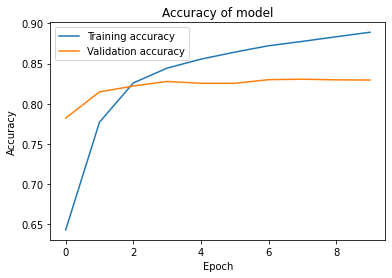

In [12]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

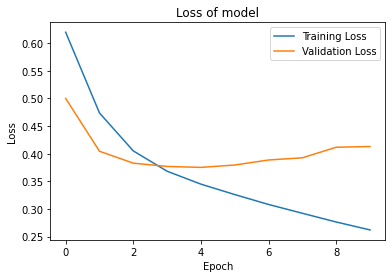

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
model.evaluate(test_data)

13/13 [==============================] - 1s 76ms/step - loss: 0.4064 - accuracy: 0.8309


[0.40639087557792664, 0.8308970332145691]

# LSTM

In [16]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [18]:
lstm_model = tf.keras.Sequential([
                                  encoder,
                                  tf.keras.layers.Embedding(
                                      input_dim=len(encoder.get_vocabulary()),
                                      output_dim=32,
                                      mask_zero=True
                                  ),
                                  tf.keras.layers.LSTM(32),
                                  tf.keras.layers.Dense(32, activation='relu'),
                                  tf.keras.layers.Dropout(0.4),
                                  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
lstm_model.evaluate(train_data)
lstm_model.evaluate(validate_data)


13/13 [==============================] - 2s 175ms/step - loss: 0.6939 - accuracy: 0.3956


[0.6938707828521729, 0.3955528140068054]

In [21]:
history = lstm_model.fit(train_data, epochs=5, validation_data=validate_data)

Epoch 1/5
102/102 [==============================] - 59s 533ms/step - loss: 0.5515 - accuracy: 0.7062 - val_loss: 0.3856 - val_accuracy: 0.8237
Epoch 2/5
102/102 [==============================] - 51s 500ms/step - loss: 0.3756 - accuracy: 0.8336 - val_loss: 0.3596 - val_accuracy: 0.8337
Epoch 3/5
102/102 [==============================] - 51s 497ms/step - loss: 0.3532 - accuracy: 0.8452 - val_loss: 0.3536 - val_accuracy: 0.8397
Epoch 4/5
102/102 [==============================] - 51s 497ms/step - loss: 0.3476 - accuracy: 0.8467 - val_loss: 0.3604 - val_accuracy: 0.8342
Epoch 5/5
102/102 [==============================] - 51s 496ms/step - loss: 0.3396 - accuracy: 0.8501 - val_loss: 0.3528 - val_accuracy: 0.8375


In [22]:
lstm_model.evaluate(test_data)

13/13 [==============================] - 4s 307ms/step - loss: 0.3436 - accuracy: 0.8448


[0.34356674551963806, 0.8448222875595093]